<a href="https://colab.research.google.com/github/Nokondi/AI-ML-Training-Code/blob/main/AI-ML/A_Star_Search_Grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A* Search on a Grid
##Introduction
[In our previous implementation of A* Search](https://colab.research.google.com/drive/1BTe6sY8JS3zm0xxxtTVnQA5R0bKP7ALL?usp=share_link), we built an algorithm that could navigate a map by translating it to a graph and finding an optimal path from the starting node to the goal node using a simple heuristic function.

What if, instead of viewing each room in our map as a node in a graph, we wanted to use distance to get a more precise path. We can use Cartesian coordinates to denote the start and goal locations. To simplify things, we can divide our map into a regular two-dimensional grid and confine movement to 8 directions. Each cell on the grid can be located using an ordered pair. We can change the dimensions of the cells to increase or decrease the granularity of the grid. We can use a simple numbering system to mark which spaces on the grid are traversable and which are blocked by an obstacle. We can use the numpy and openCV libraries to process the map image and convert it to a 2-dimensional array that satisfies these criteria.

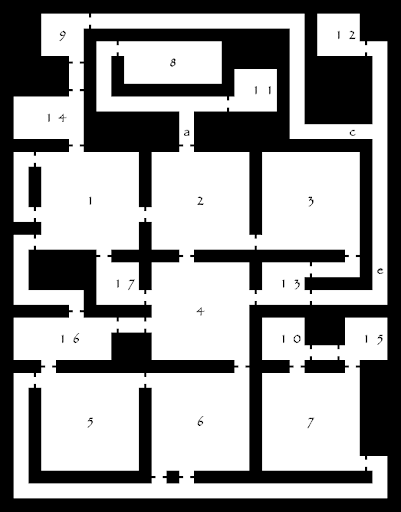

*Map generated by [Donjon](https://donjon.bin.sh/fantasy/dungeon/)*

##Imports
First, we need to import the necessary libraries (Note: urllib is needed to copy the image file from the web, and we will use the square root function in the math library in two of our cost functions).

In [32]:
import numpy as np
import cv2
import urllib
import math
from google.colab.patches import cv2_imshow

##Processing the Image
OpenCV is an image processing library that allows us to apply a number of different transformations to an image. Using the following steps, we will convert our map image to a numpy array that can be read by our algorithm.

1. Download the image data using urllib
2. Use numpy to convert the raw byte data into an array of integer values
3. Use the opencv imdecode method to decode the array data and convert it to a grayscale image. The original image data has three dimensions: width, height, and R, G, B values. Converting it to grayscale flattens the image into 2 dimensions: width and height.
4. Resize the image from its original size of 400 x 512 pixels to something more manageable. In this case, we will change it to 50 x 64.
5. We use the opencv threshold method to ensure a clear separation between black and white pixels. All pixels with a color value higher than the threshold (10) are set to the max pixel value (255), while all pixels less than the threshold are set to 0.

When we print our new map, you can see an approximation of our starting image in numeric form. 0 will represent our walls, and 255 will be the spaces our algorithm can search through.

In [41]:
url = "https://drive.google.com/uc?export=download&id=14W621LeT1pWo6AiH3wywIqLT7k_IcZQQ"
data = urllib.request.urlopen(url)
arr = np.asarray(bytearray(data.read()), dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
np.set_printoptions(threshold=10000, linewidth=300)
map = cv2.resize(img, (50,64))
x, map = cv2.threshold(map, 10, 255, cv2.THRESH_BINARY)
print(map)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0 255 255 255 255 255 255   0   0   0   0   0]
 [  0   0   0   0   0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   0 255 255 255 255 255 255   0   0   0   0   0]
 [  0   0   0   0   0 255 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255   0 255 255 255 255 255 255   0   

##Cost Functions
As we saw in the previous A* implementation, we need a heuristic to calculate the cost to move from one square to another. The cost function is:

$f(n) = g(n) + h(n)$

There are multiple ways for us to calculate distance in our cost function. The main goal is that we want a distance calculation that is accurate and will not exceed the actual distance to travel from one square to another on the grid. There are three formulas we can use: Euclidean, Manhattan, and Octile distance.

###Euclidean distance
The Euclidean distance formula should be familiar to anyone who has taken geometry: 

$A^2 + B^2 = C^2$. 

On a coordinate grid, we can rewrite this as 

$(x1 - x2)^2 + (y1 - y2)^2 = distance^2$ 

This gives us the direct line distance from one square to another on our grid.

###Manhattan distance
Manhattan distance assumes only horizontal and vertical movement and can be calculated with the following formula: 

$|x1 - x2| + |y1 - y2| = distance$

This formula will provide a more accurate distance measurement if our agent can only move in four directions.

###Octile distance
Octile distance is a variation of Manhattan distance that allows for eight directions of movement instead of four. For our simple grid, this can be calculated as follows:
$|x1 - x2| + |y1 - y2| + (√(2) - 2) * minimum |x1 - x2| or |y1 - y2|$


Below you can find functions for calculating each of these distance types. Because we are using a grid that allows for vertical, horizontal, and diagonal movement, Octile distance will be our best option in this scenario. 

In [36]:
def EucDist(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def ManDist(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def OctDist(pos1, pos2):
    dx = abs(pos1[0] - pos2[0])
    dy = abs(pos1[1] - pos2[1])
    return (dx + dy) + (math.sqrt(2) - 2) * min(dx, dy)

##A* Algorithm
In the simpler version of this algorithm, we calculated $h(n)$ for every node in the graph before searching for our path. While this was fine for a graph with a few nodes, it becomes more computationally expensive with more nodes. We will avoid this in the new algorithm by only calculating $h(n)$ for nodes our agent has seen. Also, the distance between nodes will be slightly different for nodes that are horizontally and vertically adjacent vs. nodes that are diagonally adjacent: horizontal and vertically connected nodes have a $g(n)$ value of 1, while diagonally connected nodes have a $g(n)$ of $√2$.

[[10, 25], [11, 26], [11, 27], [12, 28], [13, 29], [13, 30], [13, 31], [13, 32], [14, 33], [15, 34], [16, 35], [17, 36], [18, 36], [19, 36], [20, 36], [21, 37], [22, 38], [23, 39], [24, 40], [25, 41], [26, 42], [27, 43], [28, 44], [29, 45], [29, 46], [29, 47], [29, 48], [29, 49], [29, 50], [29, 51], [29, 52], [29, 53], [28, 54], [27, 55], [26, 56], [25, 57], [24, 58], [23, 59], [24, 60], [25, 60], [26, 60], [27, 60], [28, 60], [29, 60], [30, 60], [31, 60], [32, 60], [33, 60], [34, 60], [35, 60], [36, 60], [37, 60], [38, 60], [39, 60], [40, 60], [41, 60], [42, 60], [43, 60], [44, 60], [45, 60], [46, 59], [45, 58], [45, 57], [44, 56], [44, 55], [44, 54], [44, 53], [44, 52], [44, 51], [44, 50], [44, 49], [44, 48], [44, 47], [44, 46], [44, 45], [44, 44], [44, 43], [45, 42]]


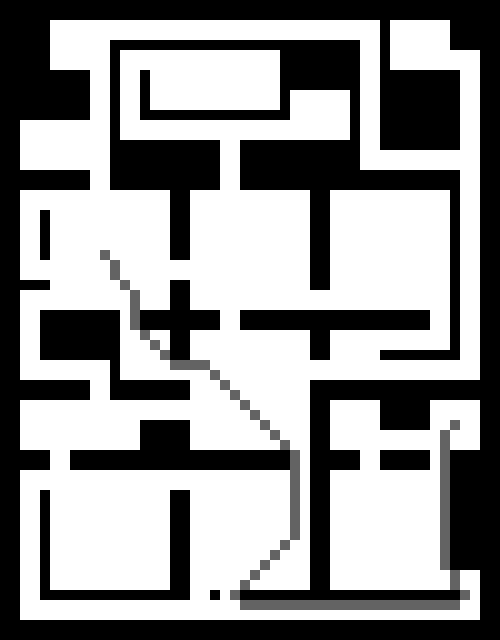

In [42]:
start = [10, 25]
goal = [45, 42]

def AStarSearchGrid(map, start, goal):
    seen = [start]
    g_list = {str(start): 0}
    parent = {str(start): None}

    while seen:
        # Step 3: retrieve node with lowest f(n) from seen
        current = []
        current_f = float('inf')
        for node in seen:
            if g_list[str(node)] + OctDist(node, goal) < current_f:
                current = node
                current_f = g_list[str(node)] + OctDist(node, goal)
        seen.remove(current)

        # Step 4: if current node is goal, exit loop
        if current == goal:
            path = [goal]
            map[goal[1]][goal[0]] = 99
            node = str(goal)
            while node != str(start):
                path.append(parent[node])
                map[parent[node][1]][parent[node][0]] = 99
                node = str(parent[node])
            path.reverse()

            return path

        for y in range(-1, 2, 1):
            for x in range(-1, 2, 1):
                xp = current[0]+x
                yp = current[1]+y
                if (yp < map.shape[0] and yp > 0) and (xp < map.shape[1] and xp > 0) and map[yp][xp] != 0:
                    neighbor_g = 0
                    if x == 0 or y == 0:
                        neighbor_g = g_list[str(current)] + 1
                    else:
                        neighbor_g = g_list[str(current)] + math.sqrt(2)
                    if str([xp, yp]) not in g_list.keys() or g_list[str([xp, yp])] > neighbor_g:
                        g_list[str([xp, yp])] = neighbor_g
                        parent[str([xp, yp])] = current
                        if [xp, yp] not in seen:
                            seen.append([xp, yp])


    return None

path = AStarSearchGrid(map, start, goal)
print(path)
map = cv2.resize(map, (500,640), interpolation=0)
cv2_imshow(map)